In [27]:
#Python-related imports
from datetime import datetime

#PyData imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from scipy.optimize import bisect
from torch.autograd import Function

In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)
    
from LogitNormal import *
from obs_and_flow import LowerBound

In [3]:
torch.manual_seed(0)
np.random.seed(0)

torch.set_printoptions(precision = 8)

## Draw $\theta \sim p(\theta)$

In [4]:
dt = 0.01
t = 100000

In [5]:
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

prior_scale_factor = 0.25

#Parameter prior means
u_M_mean = 0.0001
a_SD_mean = 0.5
a_DS_mean = 0.5
a_M_mean = 0.5
a_MSC_mean = 0.5
k_S_ref_mean = 0.00001625
k_D_ref_mean = 0.00005
k_M_ref_mean = 0.00003
Ea_S_mean = 20
Ea_D_mean = 20
Ea_M_mean = 20
s_SOC_mean = 0.0005
s_DOC_mean = 0.0005
s_MBC_mean = 0.0005

#SCON theta logit-normal distribution parameter details in order of mean, sdev, lower, and upper.
u_M_details = torch.Tensor([u_M_mean, u_M_mean * prior_scale_factor, 0, 1])
a_SD_details = torch.Tensor([a_SD_mean, a_SD_mean * prior_scale_factor, 0, 1])
a_DS_details = torch.Tensor([a_DS_mean, a_DS_mean * prior_scale_factor, 0, 1])
a_M_details = torch.Tensor([a_M_mean, a_M_mean * prior_scale_factor, 0, 1])
a_MSC_details = torch.Tensor([a_MSC_mean, a_MSC_mean * prior_scale_factor, 0, 1])
k_S_ref_details = torch.Tensor([k_S_ref_mean, k_S_ref_mean * prior_scale_factor, 0, 0.1])
k_D_ref_details = torch.Tensor([k_D_ref_mean, k_D_ref_mean * prior_scale_factor, 0, 0.1])
k_M_ref_details = torch.Tensor([k_M_ref_mean, k_M_ref_mean * prior_scale_factor, 0, 0.1])
Ea_S_details = torch.Tensor([Ea_S_mean, Ea_S_mean * prior_scale_factor, 0, 100])
Ea_D_details = torch.Tensor([Ea_D_mean, Ea_D_mean * prior_scale_factor, 0, 100])
Ea_M_details = torch.Tensor([Ea_M_mean, Ea_M_mean * prior_scale_factor, 0, 100])

#SCON-C diffusion matrix parameter distribution details
s_SOC_details = torch.Tensor([s_SOC_mean, s_SOC_mean * prior_scale_factor, 0, 0.1])
s_DOC_details = torch.Tensor([s_DOC_mean, s_DOC_mean * prior_scale_factor, 0, 0.1])
s_MBC_details = torch.Tensor([s_MBC_mean, s_MBC_mean * prior_scale_factor, 0, 0.1])

priors = {'u_M': u_M_details, 'a_SD': a_SD_details, 'a_DS': a_DS_details, 'a_M': a_M_details, 'a_MSC': a_MSC_details, 'k_S_ref': k_S_ref_details, 'k_D_ref': k_D_ref_details, 'k_M_ref': k_M_ref_details, 'Ea_S': Ea_S_details, 'Ea_D': Ea_D_details, 'Ea_M': Ea_M_details, 's_SOC': s_SOC_details, 's_DOC': s_DOC_details, 's_MBC': s_MBC_details}

In [6]:
def find_scale(scale, loc, a, b, target_sd):
    x = RescaledLogitNormal(loc, scale, a, b)
    #print(scale, x.mean, x.stddev)
    return x.stddev - target_sd

In [7]:
scale_lower = 1e-6 #Lower bound for scale search by bisect function.
scale_upper = 100 #Upper bound for scale search by bisect function. 

SCON_SS_priors_dict = {}
SCON_SS_params_dict = {}
for k, v in priors.items():
    sigmoid_loc, target_sd, a, b = v
    loc = logit(sigmoid_loc, a, b)
    scale = bisect(find_scale, scale_lower, scale_upper, (loc, a, b, target_sd))
    dist = RescaledLogitNormal(loc, scale, a, b)
    assert torch.abs(dist.stddev - target_sd) < 1e-5    
    
    SCON_SS_priors_dict[k] = torch.tensor((loc, scale, a, b))
    SCON_SS_params_dict[k] = dist.rsample().cpu().detach().numpy()

In [8]:
print(SCON_SS_params_dict)

{'u_M': array(0.00014463, dtype=float32), 'a_SD': array(0.4610014, dtype=float32), 'a_DS': array(0.23854753, dtype=float32), 'a_M': array(0.5751288, dtype=float32), 'a_MSC': array(0.35945418, dtype=float32), 'k_S_ref': array(1.162512e-05, dtype=float32), 'k_D_ref': array(5.5070424e-05, dtype=float32), 'k_M_ref': array(3.6666886e-05, dtype=float32), 'Ea_S': array(16.671965, dtype=float32), 'Ea_D': array(18.07589, dtype=float32), 'Ea_M': array(17.206264, dtype=float32), 's_SOC': array(0.00052229, dtype=float32), 's_DOC': array(0.00040717, dtype=float32), 's_MBC': array(0.00065077, dtype=float32)}


In [9]:
#Deterministic steady states:

def analytical_steady_state_init_CON(SOC_input, DOC_input, SCON_params_dict):
    '''
    Returns a vector of C pool values to initialize an SCON system corresponding to set of parameter values using the analytical steady state equations of the deterministic CON system.
    Vector elements are in order of S_0, D_0, M_0.
    Expected SCON_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, '[cs]_SOC': [cs]_SOC, '[cs]_DOC': [cs]_DOC, '[cs]_MBC': [cs]_MBC}
    '''
    D_0 = (DOC_input + SOC_input * SCON_params_dict['a_SD']) / (SCON_params_dict['u_M'] + SCON_params_dict['k_D_ref'] + SCON_params_dict['u_M'] * SCON_params_dict['a_M'] * (SCON_params_dict['a_MSC'] - 1 - SCON_params_dict['a_MSC'] * SCON_params_dict['a_SD']) - SCON_params_dict['a_DS'] * SCON_params_dict['k_D_ref'] * SCON_params_dict['a_SD'])
    S_0 = (SOC_input + D_0 * (SCON_params_dict['a_DS'] * SCON_params_dict['k_D_ref'] + SCON_params_dict['u_M'] * SCON_params_dict['a_M'] * SCON_params_dict['a_MSC'])) / SCON_params_dict['k_S_ref']
    M_0 = SCON_params_dict['u_M'] * D_0 / SCON_params_dict['k_M_ref']
    C_0_vector = torch.as_tensor([S_0, D_0, M_0])    
    #CO2_0 = SCON_params_dict['k_S_ref'] * S_0 * (1 - SCON_params_dict['a_SD']) + SCON_params_dict['k_D_ref'] * D_0 * (1 - SCON_params_dict['a_DS']) + SCON_params_dict['k_M_ref'] * M_0 * (1 - SCON_params_dict['a_M'])
    #C_0_vector = torch.as_tensor([S_0, D_0, M_0, CO2_0])
    return C_0_vector

def analytical_steady_state_init_AWB(SOC_input, DOC_input, SAWB_params_dict):
    '''
    Returns a vector of C pool values to initialize an SAWB system corresponding to set of parameter values using the analytical steady state equations of the deterministic CON system.
    Vector elements are in order of S_0, D_0, M_0, E_0.
    Expected SAWB_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_D': K_D, 'K_U': K_U, 'V_D_ref': V_D_ref, 'V_U_ref': V_U_ref, 'Ea_V_D': Ea_V_D, 'Ea_V_U': Ea_V_U, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, '[cs]_SOC': [cs]_SOC, '[cs]_DOC': [cs]_DOC, '[cs]_MBC': [cs]_MBC, '[cs]_EEC': [cs]_EEC}
    '''
    S_0 = -((SAWB_params_dict['K_D'] * SAWB_params_dict['r_L'] * (SOC_input * SAWB_params_dict['r_E'] * (SAWB_params_dict['u_Q_ref'] - 1) - SAWB_params_dict['a_MSA'] * DOC_input * SAWB_params_dict['r_M'] * SAWB_params_dict['u_Q_ref'] + SOC_input * SAWB_params_dict['r_M'] * (-1 + SAWB_params_dict['u_Q_ref'] - SAWB_params_dict['a_MSA'] * SAWB_params_dict['u_Q_ref']))) / (DOC_input * SAWB_params_dict['u_Q_ref'] * (-SAWB_params_dict['a_MSA'] * SAWB_params_dict['r_L'] * SAWB_params_dict['r_M'] + SAWB_params_dict['r_E'] * SAWB_params_dict['V_D_ref']) + SOC_input * (SAWB_params_dict['r_E'] * SAWB_params_dict['r_L'] * (SAWB_params_dict['u_Q_ref'] - 1) + SAWB_params_dict['r_L'] * SAWB_params_dict['r_M'] * (-1 + SAWB_params_dict['u_Q_ref'] - SAWB_params_dict['a_MSA'] * SAWB_params_dict['u_Q_ref']) + SAWB_params_dict['r_E'] * SAWB_params_dict['u_Q_ref'] * SAWB_params_dict['V_D_ref'])))
    D_0 = -((SAWB_params_dict['K_U'] * (SAWB_params_dict['r_E'] + SAWB_params_dict['r_M'])) / (SAWB_params_dict['r_E'] + SAWB_params_dict['r_M'] - SAWB_params_dict['u_Q_ref'] * SAWB_params_dict['V_U_ref']))
    M_0 = -((SOC_input + DOC_input) * SAWB_params_dict['u_Q_ref']) / ((SAWB_params_dict['r_E'] + SAWB_params_dict['r_M']) * (SAWB_params_dict['u_Q_ref'] - 1))
    E_0 = SAWB_params_dict['r_E'] * M_0 / SAWB_params_dict['r_L']
    C_0_vector = torch.as_tensor([S_0, D_0, M_0, E_0])    
    #E_0 = -((SAWB_params_dict['r_E'] * SAWB_params_dict['u_Q_ref'] * (SOC_input + DOC_input)) / (SAWB_params_dict['r_L'] * (SAWB_params_dict['r_E'] + SAWB_params_dict['r_M']) * (SAWB_params_dict['u_Q_ref'] - 1)))
    #CO2_0 = (1 - SAWB_params_dict['u_Q_ref']) * (SAWB_params_dict['V_U_ref'] * M_0 * D_0) / (SAWB_params_dict['K_U'] + D_0)
    #C_0_vector = torch.as_tensor([S_0, D_0, M_0, E_0, CO2_0])
    return C_0_vector

def analytical_steady_state_init_AWB_ECA(SOC_input, DOC_input, SAWB_ECA_params_dict):
    '''
    Returns a vector of C pool values to initialize an SAWB-ECA system corresponding to set of parameter values using the analytical steady state equations of the deterministic CON system.
    Vector elements are in order of S_0, D_0, M_0, E_0.
    Expected SAWB_ECA_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_DE': K_DE, 'K_UE': K_UE, 'V_DE_ref': V_DE_ref, 'V_UE_ref': V_UE_ref, 'Ea_V_DE': Ea_V_DE, 'Ea_V_UE': Ea_V_UE, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, '[cs]_SOC': [cs]_SOC, '[cs]_DOC': [cs]_DOC, '[cs]_MBC': [cs]_MBC, '[cs]_EEC': [cs]_EEC}
    '''
    S_0 = ((-SAWB_ECA_params_dict['K_DE'] * SAWB_ECA_params_dict['r_L'] * (SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M']) * (SAWB_ECA_params_dict['u_Q_ref'] - 1) + SAWB_ECA_params_dict['r_E'] * SAWB_ECA_params_dict['u_Q_ref'] * (SOC_input + DOC_input)) * (SOC_input * SAWB_ECA_params_dict['r_E'] * (SAWB_ECA_params_dict['u_Q_ref'] - 1) - SAWB_ECA_params_dict['a_MSA'] * DOC_input * SAWB_ECA_params_dict['r_M'] * SAWB_ECA_params_dict['u_Q_ref'] + SOC_input * SAWB_ECA_params_dict['r_M'] * (SAWB_ECA_params_dict['u_Q_ref'] - SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['u_Q_ref'] - 1))) / ((SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M']) * (SAWB_ECA_params_dict['u_Q_ref'] - 1) * (DOC_input * SAWB_ECA_params_dict['u_Q_ref'] * (SAWB_ECA_params_dict['r_E'] * SAWB_ECA_params_dict['V_DE_ref'] - SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['r_L'] * SAWB_ECA_params_dict['r_M']) + SOC_input * (SAWB_ECA_params_dict['r_E'] * SAWB_ECA_params_dict['r_L'] * (SAWB_ECA_params_dict['u_Q_ref'] - 1) + SAWB_ECA_params_dict['r_L'] * SAWB_ECA_params_dict['r_M'] * (SAWB_ECA_params_dict['u_Q_ref'] - SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['u_Q_ref'] - 1) + SAWB_ECA_params_dict['r_E'] * SAWB_ECA_params_dict['u_Q_ref'] * SAWB_ECA_params_dict['V_DE_ref'])))
    D_0 = -(SAWB_ECA_params_dict['K_UE'] * (SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M']) * (SAWB_ECA_params_dict['u_Q_ref'] - 1) - (SOC_input + DOC_input) * SAWB_ECA_params_dict['u_Q_ref']) / ((SAWB_ECA_params_dict['u_Q_ref'] - 1) * (SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M'] - SAWB_ECA_params_dict['u_Q_ref'] * SAWB_ECA_params_dict['V_UE_ref']))
    M_0 = -((SOC_input + DOC_input) * SAWB_ECA_params_dict['u_Q_ref']) / ((SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M']) * (SAWB_ECA_params_dict['u_Q_ref'] - 1))
    E_0 = SAWB_ECA_params_dict['r_E'] * M_0 / SAWB_ECA_params_dict['r_L']
    C_0_vector = torch.as_tensor([S_0, D_0, M_0, E_0])    
    #E_0 = -((SAWB_params_dict['r_E'] * SAWB_params_dict['u_Q_ref'] * (SOC_input + DOC_input)) / (SAWB_params_dict['r_L'] * (SAWB_params_dict['r_E'] + SAWB_params_dict['r_M']) * (SAWB_params_dict['u_Q_ref'] - 1)))
    #CO2_0 = (1 - SAWB_ECA_params_dict['u_Q_ref']) * SAWB_ECA_params_dict['V_UE_ref'] * M_0 * D_0 / (SAWB_ECA_params_dict['K_UE'] + M_0 + D_0)
    #C_0_vector = torch.as_tensor([S_0, D_0, M_0, E_0, CO2_0])
    return C_0_vector

In [10]:
SOC0, DOC0, MBC0 = analytical_steady_state_init_CON(0.001, 0.0001, SCON_SS_params_dict)
print(SOC0, DOC0, MBC0)

tensor(102.42809354, dtype=torch.float64) tensor(4.43202591, dtype=torch.float64) tensor(17.48174799, dtype=torch.float64)


In [ ]:
# Save reparameterized prior and sampled theta
now = datetime.now()
sbm_model = 'SCON-SS_CO2_logit_alt' + now.strftime('_%Y_%m_%d_%H_%M')
dir_path = '../generated_data/'
save_string = dir_path + f'{sbm_model}_sample_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
torch.save(SCON_SS_priors_dict, save_string + '_hyperparams.pt')
torch.save(SCON_SS_params_dict, save_string + '_rsample.pt') 

### Visualize sampled $\theta$

In [11]:
keys = list(SCON_SS_priors_dict.keys())
loc, scale, a, b = torch.tensor(list(zip(*(SCON_SS_priors_dict[k] for k in keys))))
loc, scale, a, b

(tensor([-9.21024036,  0.00000000,  0.00000000,  0.00000000,  0.00000000,
         -8.72467041, -7.60040236, -8.11142731, -1.38629436, -1.38629436,
         -1.38629436, -5.29330492, -5.29330492, -5.29330492]),
 tensor([0.23948750, 0.53270829, 0.53270829, 0.53270829, 0.53270829, 0.23950477,
         0.23959713, 0.23954222, 0.30971119, 0.30971119, 0.30971119, 0.24083875,
         0.24083875, 0.24083875]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([  1.00000000,   1.00000000,   1.00000000,   1.00000000,   1.00000000,
           0.10000000,   0.10000000,   0.10000000, 100.00000000, 100.00000000,
         100.00000000,   0.10000000,   0.10000000,   0.10000000]))

In [12]:
dist = RescaledLogitNormal(loc, scale, a, b)
x0 = torch.max(dist.mean - 4*dist.stddev, a).detach()
x1 = torch.min(dist.mean + 4*dist.stddev, b).detach()

num_pts = 1000
x = torch.from_numpy(np.linspace(x0, x1, num_pts))
pdf = torch.exp(dist.log_prob(x)).detach()

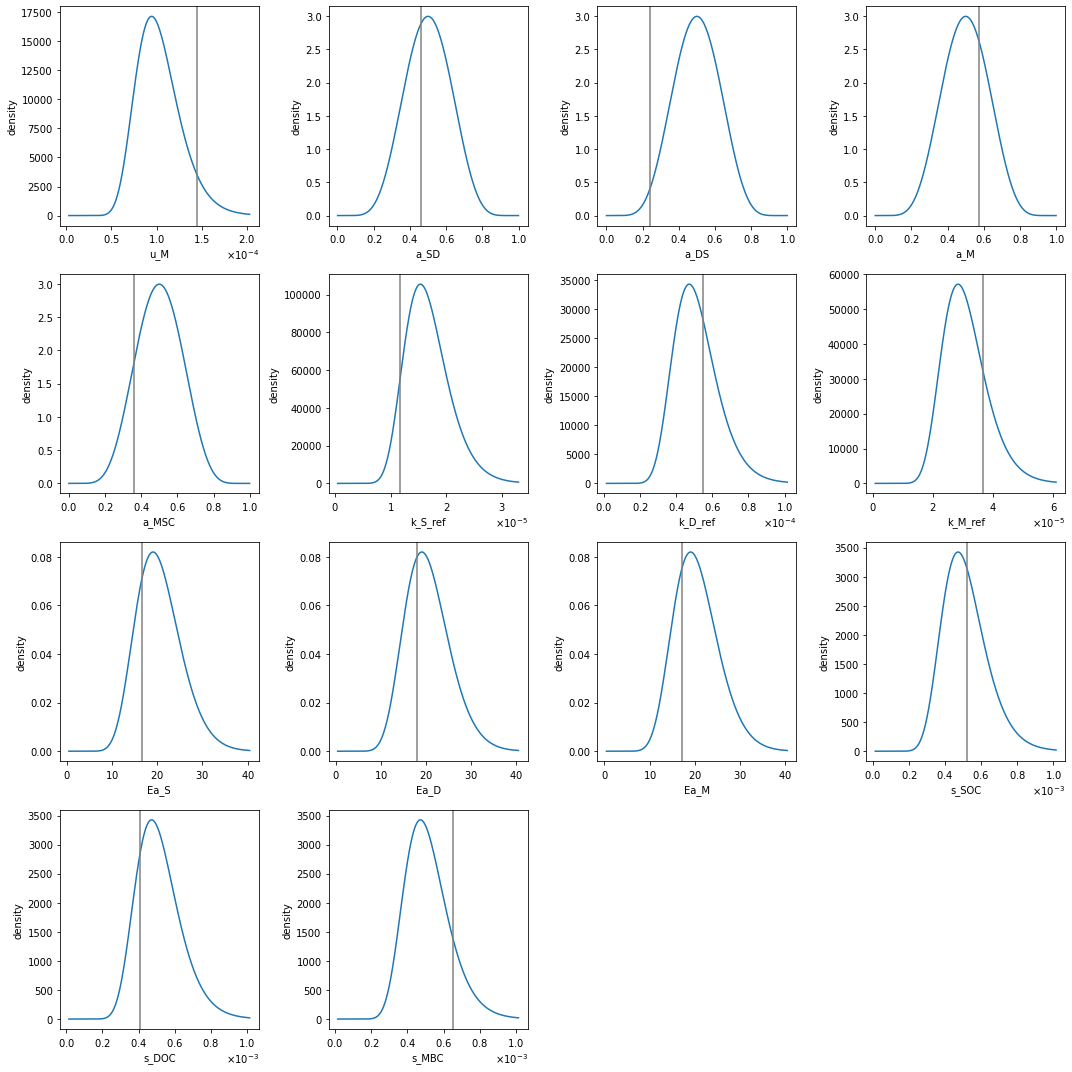

In [29]:
# Save sampled theta values
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
k = 0
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if k < 14:
            key = keys[k]
            ax.plot(x[:, k], pdf[:, k])
            ax.axvline(SCON_SS_params_dict[key], color='gray')
            ax.set_xlabel(key)
            ax.set_ylabel('density')
            ax.ticklabel_format(style='sci', scilimits=(-2,4), axis='x', useMathText='True')
        else:
            fig.delaxes(axes[i, j])
        k += 1  
plt.tight_layout()

## Draw $x, y \sim p(x|\theta) p(y|x)$

In [ ]:
def temp_func(t, TEMP_REF, TEMP_RISE):
    temp = TEMP_REF + (TEMP_RISE * t) / (80 * 24 * 365) + 10 * np.sin((2 * np.pi / 24) * t) + 10 * np.sin((2 * np.pi / (24 * 365)) * t)
    return temp

def I_S_func(t):
    return 0.001 + 0.0005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous SOC input function

def I_D_func(t):
    return 0.0001 + 0.00005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous DOC input function

def arrhenius_temp(parameter, temp, Ea, temp_ref):
    '''
    For a parameter with Arrhenius temperature dependence, returns the transformed parameter value.
    0.008314 is the gas constant. Temperatures are in K.
    '''
    decayed_parameter = parameter * np.exp(-Ea / 0.008314 * (1 / temp - 1 / temp_ref))
    return decayed_parameter

def linear_temp(parameter, temp, Q, temp_ref):
    '''
    For a parameter with linear temperature dependence, returns the transformed parameter value.
    Q is the slope of the temperature dependence and is a varying parameter.
    Temperatures are in K.
    '''
    modified_parameter = parameter - Q * (temp - temp_ref)
    return modified_parameter

In [ ]:
#Generate data from SBM SDEs
#x in order of SOC, DOC, MBC (and EEC for AWB family models)

def alpha_SCON(x, SCON_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], temp_ref)
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], temp_ref)
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], temp_ref)
    #Evolve drift.
    SOC = I_S + SCON_params_dict['a_DS'] * k_D * x[1] + SCON_params_dict['a_M'] * SCON_params_dict['a_MSC'] * k_M * x[2] - k_S * x[0]
    DOC = I_D + SCON_params_dict['a_SD'] * k_S * x[0] + SCON_params_dict['a_M'] * (1 - SCON_params_dict['a_MSC']) * k_M * x[2] - (SCON_params_dict['u_M'] + k_D) * x[1]
    MBC = SCON_params_dict['u_M'] * x[1] - k_M * x[2]
    return np.array([SOC, DOC, MBC])

def beta_SCON_C(x, SCON_C_params_dict):
    b11 = SCON_C_params_dict['c_SOC']
    b22 = SCON_C_params_dict['c_DOC']
    b33 = SCON_C_params_dict['c_MBC']
    return np.diag([b11, b22, b33])

def beta_SCON_SS(x, SCON_SS_params_dict):
    b11 = SCON_SS_params_dict['s_SOC'] * x[0]
    b22 = SCON_SS_params_dict['s_DOC'] * x[1]
    b33 = SCON_SS_params_dict['s_MBC'] * x[2]
    return np.diag([b11, b22, b33])

def alpha_SAWB(x, SAWB_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], temp_ref)
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], temp_ref)
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_params_dict['a_MSA'] * SAWB_params_dict['r_M'] * x[2] - ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0]))
    DOC = I_D + (1 - SAWB_params_dict['a_MSA']) * SAWB_params_dict['r_M'] * x[2] + ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0])) + SAWB_params_dict['r_L'] * x[3] - ((V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1]))
    MBC = (u_Q * (V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1])) - (SAWB_params_dict['r_M'] + SAWB_params_dict['r_E']) * x[2]
    EEC = SAWB_params_dict['r_E'] * x[2] - SAWB_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_C(x, SAWB_C_params_dict):
    b11 = SAWB_C_params_dict['c_SOC']
    b22 = SAWB_C_params_dict['c_DOC']
    b33 = SAWB_C_params_dict['c_MBC']
    b44 = SAWB_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_SS(x, SAWB_SS_params_dict):
    b11 = SAWB_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])

def alpha_SAWB_ECA(x, SAWB_ECA_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], temp_ref)
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], temp_ref)
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['r_M'] * x[2] - ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0]))
    DOC = I_D + (1 - SAWB_ECA_params_dict['a_MSA']) * SAWB_ECA_params_dict['r_M'] * x[2] + ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0])) + SAWB_ECA_params_dict['r_L'] * x[3] - ((V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1]))
    MBC = (u_Q * (V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1])) - (SAWB_ECA_params_dict['r_M'] + SAWB_ECA_params_dict['r_E']) * x[2]
    EEC = SAWB_ECA_params_dict['r_E'] * x[2] - SAWB_ECA_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_ECA_C(x, SAWB_ECA_C_params_dict):
    b11 = SAWB_ECA_C_params_dict['c_SOC']
    b22 = SAWB_ECA_C_params_dict['c_DOC']
    b33 = SAWB_ECA_C_params_dict['c_MBC']
    b44 = SAWB_ECA_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_ECA_SS(x, SAWB_ECA_SS_params_dict):
    b11 = SAWB_ECA_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_ECA_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_ECA_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_ECA_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])

In [ ]:
def get_CO2_CON_gen_y(x, SCON_params_dict, current_temp, TEMP_REF):
    state_dim = 3 #SCON has three state variables in SOC, DOC, and MBC.
    SOC, DOC, MBC =  np.array_split(x, state_dim, 0) #Partition SOC, DOC, and MBC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor.
    #Decay parameters are forced by temperature changes.    
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_S_ref.
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_D_ref.
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_M_ref.
    CO2 = (k_S * SOC * (1 - SCON_params_dict['a_SD'])) + (k_D * DOC * (1 - SCON_params_dict['a_DS'])) + (k_M * MBC * (1 - SCON_params_dict['a_M']))
    return CO2

def get_CO2_AWB_gen_y(x, SAWB_params_dict, current_temp, TEMP_REF):
    state_dim = 4 #SAWB and SAWB-ECA have four state variables in SOC, DOC, MBC, and EEC.
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 0) #Partition SOC, DOC, MBC, EEC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor. 
    #Decay parameters are forced by temperature changes.    
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], TEMP_REF) #Apply linear temperature-dependence to u_Q.
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_D.
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_U.
    CO2 = (1 - u_Q) * (V_U * MBC * DOC) / (SAWB_params_dict['K_U'] + MBC + DOC)
    return CO2

def get_CO2_AWB_ECA_gen_y(x, SAWB_ECA_params_dict, current_temp, TEMP_REF):
    state_dim = 4 #SAWB and SAWB-ECA have four state variables in SOC, DOC, MBC, and EEC.
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 0) #Partition SOC, DOC, MBC, EEC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor. 
    #Decay parameters are forced by temperature changes.    
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], TEMP_REF) #Apply linear temperature-dependence to u_Q.
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_DE.
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_UE.
    CO2 = (1 - u_Q) * (V_UE * MBC * DOC) / (SAWB_ECA_params_dict['K_UE'] + MBC + DOC)
    return CO2

In [ ]:
def get_SBM_SDE_euler_maruyama_y(ALPHA, BETA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, TEMP_REF, TEMP_RISE, OBS_EVERY, OBS_ERROR_SCALE, lower_bound = 1e-4):
    state_dim = 0
    get_CO2_gen_y = None
    if ALPHA == alpha_SCON:
        state_dim = 3
        get_CO2_gen_y = get_CO2_CON_gen_y
    elif ALPHA == alpha_SAWB:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_gen_y
    elif ALPHA == alpha_SAWB_ECA:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_ECA_gen_y
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    CO2 = np.zeros([1, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample
    CO2[:, 0] = get_CO2_gen_y(x[:, 0], THETA_DICT, TEMP_FUNC(0, TEMP_REF, TEMP_RISE), TEMP_REF)
    hour = 0
    for i in range(1, N):
        hour += DT
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, TEMP_REF, TEMP_RISE)
        #print('current_temp', current_temp)
        #Take Euler-Maruyama step. Note: np.random.normal takes std while np.random.multivariate_normal takes cov.
        x[:, i] = np.random.multivariate_normal(mean = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, TEMP_REF, arrhenius_temp, linear_temp) * DT, cov = BETA(x[:, i - 1], THETA_DICT) * DT)
        x[:, i][x[:, i] < lower_bound] = lower_bound #Bound all x above 0.
        #print('x at i', x[:, i])
        CO2[:, i] = get_CO2_gen_y(x[:, i], THETA_DICT, current_temp, TEMP_REF) #Compute CO2.
    x_with_CO2 = np.concatenate((x, CO2), 0)
    x_with_CO2_for_y = x_with_CO2[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_with_CO2_for_y.mean(1)
    y = x_with_CO2_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_with_CO2_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'y_std': obs_var_scale, 'x': x_with_CO2, 't_x': np.arange(0, T + DT, DT)}

def get_SBM_SDE_euler_maruyama_y_det(ALPHA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, TEMP_REF, TEMP_RISE, OBS_EVERY, OBS_ERROR_SCALE, lower_bound = 1e-4):
    state_dim = 0
    get_CO2_gen_y = None
    if ALPHA == alpha_SCON:
        state_dim = 3
        get_CO2_gen_y = get_CO2_CON_gen_y
    elif ALPHA == alpha_SAWB:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_gen_y
    elif ALPHA == alpha_SAWB_ECA:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_ECA_gen_y
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    CO2 = np.zeros([1, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample
    CO2[:, 0] = get_CO2_gen_y(x[:, 0], THETA_DICT, TEMP_FUNC(0, TEMP_REF, TEMP_RISE), TEMP_REF) #Compute initial CO2.
    hour = 0
    for i in range(1, N):
        hour += DT
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, TEMP_REF, TEMP_RISE)
        #print('current_temp', current_temp)
        #Take Euler.
        x[:, i] = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, TEMP_REF, arrhenius_temp, linear_temp) * DT
        x[:, i][x[:, i] < lower_bound] = lower_bound #Bound all x above 0.
        #print('x at i', x[:, i])
        CO2[:, i] = get_CO2_gen_y(x[:, i], THETA_DICT, current_temp, TEMP_REF) #Compute CO2. 
    x_with_CO2 = np.concatenate((x, CO2), 0)
    x_with_CO2_for_y = x_with_CO2[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_with_CO2_for_y.mean(1)
    y = x_with_CO2_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_with_CO2_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'y_std': obs_var_scale, 'x': x_with_CO2, 't_x': np.arange(0, T + DT, DT)}

In [ ]:
x0_SCON = [65, 0.4, 2.5]
obs_every = 5
obs_error_scale = 0.1

In [ ]:
y_dict = get_SBM_SDE_euler_maruyama_y(alpha_SCON, beta_SCON_SS, x0_SCON, t, dt, SCON_SS_params_dict, I_S_func, I_D_func, temp_func, temp_ref, temp_rise, obs_every, obs_error_scale)

In [ ]:
#Save CSV of stochastic path.
df_y = pd.DataFrame(data = {'hour': y_dict['t_y'], 'SOC': y_dict['y'][0, :], 'DOC': y_dict['y'][1, :], 'MBC': y_dict['y'][2, :], 'CO2': y_dict['y'][3, :]})
df_y.to_csv(save_string + '.csv', index = False)

In [ ]:
print(df_y)

### Visualize sampled $x$

In [ ]:
fig, axs = plt.subplots(4, sharex = True)
axs[0].plot(y_dict['t_x'], y_dict['x'][0, :], color = "m", label = 'SOC x')
axs[0].scatter(y_dict['t_y'], y_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs[1].plot(y_dict['t_x'], y_dict['x'][1, :], color = "c", label = 'DOC x')
axs[1].scatter(y_dict['t_y'], y_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs[2].plot(y_dict['t_x'], y_dict['x'][2, :], color = "g", label = 'MBC x')
axs[2].scatter(y_dict['t_y'], y_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')
axs[3].plot(y_dict['t_x'], y_dict['x'][3, :], color = "orange", label = 'CO2')
axs[3].scatter(y_dict['t_y'], y_dict['y'][3, :], color = "orange", alpha = 0.3, label = 'CO2 y')

In [ ]:
fig.savefig(save_string + '.png', dpi = 300)

## Generate deterministic $x$

In [ ]:
y_det_dict = get_SBM_SDE_euler_maruyama_y_det(alpha_SCON, x0_SCON, t, dt, SCON_SS_params_dict, I_S_func, I_D_func, temp_func, temp_ref, temp_rise, obs_every, obs_error_scale)

In [ ]:
fig2, axs2 = plt.subplots(4, sharex = True)
axs2[0].plot(y_det_dict['t_x'], y_det_dict['x'][0, :], color = "m", label = 'SOC x')
axs2[0].scatter(y_det_dict['t_y'], y_det_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs2[1].plot(y_det_dict['t_x'], y_det_dict['x'][1, :], color = "c", label = 'DOC x')
axs2[1].scatter(y_det_dict['t_y'], y_det_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs2[2].plot(y_det_dict['t_x'], y_det_dict['x'][2, :], color = "g", label = 'MBC x')
axs2[2].scatter(y_det_dict['t_y'], y_det_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')
axs2[3].plot(y_det_dict['t_x'], y_det_dict['x'][3, :], color = "orange", label = 'CO2')
axs2[3].scatter(y_det_dict['t_y'], y_det_dict['y'][3, :], color = "orange", alpha = 0.3, label = 'CO2 y')

In [ ]:
save_string_det = dir_path + f'{sbm_model}_prior_alt_sample_det_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
fig2.savefig(save_string_det + '.png', dpi = 300)

In [ ]:
df_y_det = pd.DataFrame(data = {'hour': y_det_dict['t_y'], 'SOC': y_det_dict['y'][0, :], 'DOC': y_det_dict['y'][1, :], 'MBC': y_det_dict['y'][2, :], 'CO2': y_det_dict['y'][3, :]})
df_y_det.to_csv(save_string_det + '.csv', index = False)

In [ ]:
print(df_y_det)